# Day 7 — Mini Evaluation Project: Full ML Evaluation Workflow
### Machine Learning Roadmap — Week 3
### Author — N Manish Kumar
---

In this project, we apply the complete model evaluation workflow learned
throughout Week 3 on a real classification dataset.

Instead of focusing only on accuracy, we will evaluate models using:
- Cross-validation
- Bias–variance diagnosis
- Error analysis
- Precision, Recall, and F1-score
- Threshold tuning using ROC and PR curves

The goal is to select a final model and decision threshold based on
data-driven reasoning, not guesswork.

Dataset used: **Breast Cancer Dataset (sklearn)**

Application context: **Medical screening — missing positive cases is costly**

---

## 1. Import Libraries, Load Dataset, and Create Train/Test Split

We first load the Breast Cancer dataset and create a hold-out test set.

All model selection and diagnostics will be performed only on the training data.

The test set will be used at the very end for final confirmation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, auc
)

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (455, 30)
Test set shape: (114, 30)


### Interpretation

The dataset is split into training and test sets.

All model comparison, learning curves, and tuning will bem done using only
the training data to avoid test set leakage.

The test set will be used only once for final evaluation.

---


## 2. Train Baseline Models

We begin by training two simple baseline models:

1. Logistic Regression (linear model with regularization)
2. Decision Tree (non-linear model with limited depth)

These models will later be compared using cross-validation and further
diagnostics to decide which one is more suitable for this dataset.

In [2]:
# Logistic Regression pipeline
log_reg_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=10000, solver="saga"))
])

# Decision Tree model
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Train both models
log_reg_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

### Interpretation

Both baseline models have now been trained on the training data.

Logistic Regression provides a strong linear baseline, while the Decision Tree
can capture non-linear relationships but may overfit if too complex.

In the next step, we will compare these models using cross-validation to
decide which model is more stable and performs better on unseen data.

---

## 3. Cross-Validation Comparison of Baseline Models

Evaluating models on a single train–test split can give misleading results
because performance may depend on how the data was split.

To obtain a more reliable estimate of model performance, we use
**k-fold cross-validation** on the training data.

Cross-validation:
- Splits the training data into k parts (folds)
- Trains the model on k−1 folds
- Validates it on the remaining fold
- Repeats this process k times

This provides:
- Mean validation accuracy → overall performance
- Standard deviation → stability across different splits

We will compare Logistic Regression and Decision Tree using 5-fold CV.

In [3]:
# Dictionary of models for evaluation
models = {
    "Logistic Regression": log_reg_model,
    "Decision Tree": tree_model
}

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    
    cv_results[name] = {
        "mean_accuracy": scores.mean(),
        "std_accuracy": scores.std()
    }

cv_results

{'Logistic Regression': {'mean_accuracy': np.float64(0.9802197802197803),
  'std_accuracy': np.float64(0.012815278889769896)},
 'Decision Tree': {'mean_accuracy': np.float64(0.9318681318681318),
  'std_accuracy': np.float64(0.021308482889742106)}}

### Interpretation

The mean cross-validation accuracy represents how well each model performs
on average across different data splits.

The standard deviation indicates how sensitive the model is to variations
in training data. A lower standard deviation means the model is more stable.

When selecting a model, we prefer:
- Higher mean accuracy
- Lower standard deviation

This helps us choose models that not only perform well but also generalize
consistently to unseen data.

---

## 4. Bias–Variance Diagnosis Using Learning Curves

After selecting the better-performing model using cross-validation, the next
question is whether the model is:

- Underfitting (high bias)
- Overfitting (high variance)
- Or reasonably balanced

Learning curves show how training and validation performance change as the
amount of training data increases.

By analyzing these curves, we can decide:
- Whether collecting more data may help
- Whether a more complex model might be required


Selected model for learning curves: Logistic Regression


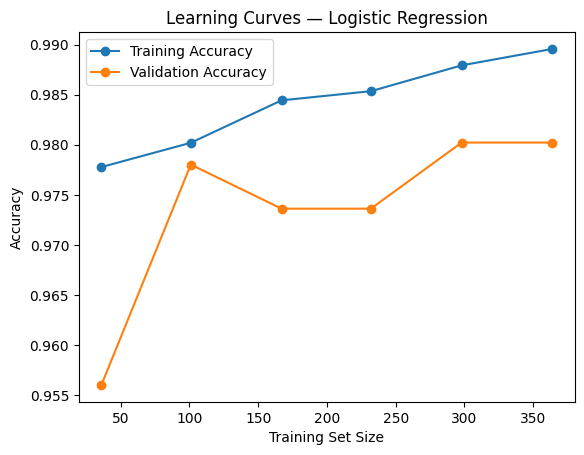

In [4]:
# Select best model based on CV mean accuracy
best_model_name = max(cv_results, key=lambda k: cv_results[k]["mean_accuracy"])
best_model = models[best_model_name]

print("Selected model for learning curves:", best_model_name)

# Compute learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

# Mean scores
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label="Training Accuracy")
plt.plot(train_sizes, val_mean, marker='o', label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title(f"Learning Curves — {best_model_name}")
plt.legend()
plt.show()

### Interpretation

If both training and validation accuracies are low and close together,
the model is underfitting and may benefit from higher complexity or better
features.

If training accuracy is high but validation accuracy is much lower, the model
is overfitting and may benefit from more data or stronger regularization.

If both curves converge to high values, the model is well-balanced and
additional improvements may require better features rather than more data.

---

## 5. Error Analysis on the Test Set

After selecting the best model and diagnosing bias–variance behavior, we now
evaluate the model on the untouched test set and analyze its mistakes.

Instead of only reporting accuracy, we inspect:
- Confusion matrix
- False Positives (FP)
- False Negatives (FN)

In medical screening, false negatives are especially dangerous because they
represent missed positive cases. Therefore, understanding the type of errors
is more important than just overall accuracy.


In [5]:
# Train best model on full training data
best_model.fit(X_train, y_train)

# Predictions on test set
y_test_pred = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[41,  1],
       [ 1, 71]])

In [6]:
# Extract FP and FN counts
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

True Negatives: 41
False Positives: 1
False Negatives: 1
True Positives: 71


### Interpretation

False negatives represent actual positive cases that the model failed to
detect, which is critical in medical applications.

False positives represent cases flagged as positive but are actually negative,
which may lead to unnecessary follow-up tests.

Depending on which error is more costly, we may need to adjust the model or
change the decision threshold to reduce the more harmful error type.

---

## 6. Evaluation Using Precision, Recall, and F1-Score

Accuracy alone does not reflect how serious different types of errors are.

For medical screening:
- **Recall** is critical → we want to detect as many true positive cases as possible
- **Precision** is also important → but slightly less critical than recall
- **F1-score** balances both

We now compute these metrics on the test set to better understand the model's
real-world usefulness.


In [7]:
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)

Test Precision: 0.9861111111111112
Test Recall: 0.9861111111111112
Test F1-score: 0.9861111111111112


### Interpretation

Recall indicates how many actual positive cases the model successfully detected.
If recall is low, many patients would be missed.

Precision indicates how many predicted positive cases are truly positive.
Lower precision means more false alarms.

F1-score summarizes the balance between precision and recall and is useful when
both types of errors matter.

If recall is not high enough, we may prefer to adjust the decision threshold
to improve detection even if precision drops slightly.

---

## 7. ROC & Precision–Recall Curves for Final Model

So far, predictions were made using the default probability threshold of 0.5.

However, classification models actually output probabilities, and we can
change the threshold to control the trade-off between:
- Recall (detecting positives)
- Precision (avoiding false alarms)

To visualize this trade-off across all thresholds, we use:
- ROC Curve (TPR vs FPR)
- Precision–Recall Curve (Precision vs Recall)

For imbalanced and medical datasets, the Precision–Recall curve is usually
more informative.


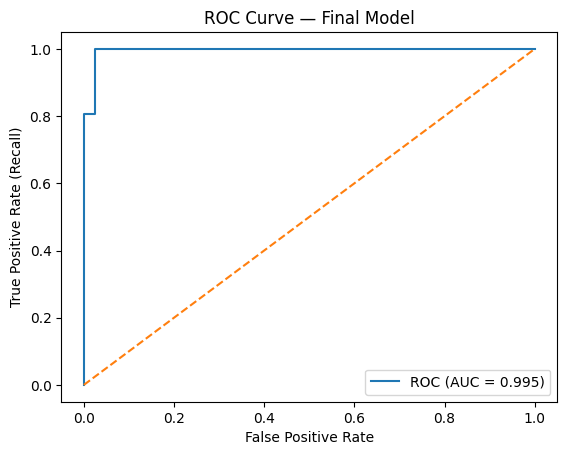

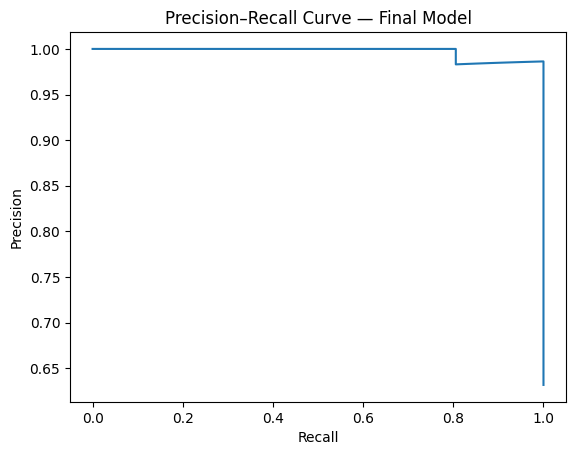

In [8]:
# Predicted probabilities for positive class
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — Final Model")
plt.legend()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_test_prob)

plt.figure()
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Final Model")
plt.show()

### Interpretation

The ROC curve shows how recall increases as we allow more false positives, and
AUC summarizes overall class separation ability.

The Precision–Recall curve shows how precision drops as recall increases, which
is more meaningful when positive cases are rare.

For medical screening, we usually prefer operating points with very high recall,
even if precision decreases, to avoid missing positive cases.

---

## 8. Threshold Tuning and Final Model Decision

The default threshold of 0.5 may not provide the best balance between
precision and recall for medical screening.

Since missing positive cases is dangerous, we aim to choose a threshold
that increases recall while keeping precision at an acceptable level.

We test several thresholds and compare:
- Precision
- Recall
- F1-score

The chosen threshold should align with the medical goal of detecting as
many true positive cases as possible.

In [9]:
thresholds_to_test = [0.2, 0.3, 0.4, 0.5]

threshold_results = []

for t in thresholds_to_test:
    y_pred_t = (y_test_prob >= t).astype(int)
    
    threshold_results.append({
        "Threshold": t,
        "Precision": precision_score(y_test, y_pred_t),
        "Recall": recall_score(y_test, y_pred_t),
        "F1": f1_score(y_test, y_pred_t)
    })

pd.DataFrame(threshold_results)

,Threshold,Precision,Recall,F1
0,0.2,0.972973,1.000000,0.986301
1,0.3,0.972973,1.000000,0.986301
2,0.4,0.986111,0.986111,0.986111
3,0.5,0.986111,0.986111,0.986111


### Interpretation

Lower thresholds generally increase recall, meaning fewer positive cases are
missed, but this comes at the cost of lower precision.

Higher thresholds increase precision but may miss more true positive cases.

For medical screening, it is usually acceptable to tolerate more false positives
if it significantly reduces false negatives.

Based on these results, a threshold that achieves very high recall while keeping
reasonable precision should be selected as the final operating point.

---

# Notebook Summary — Week 3 Day 7 (Mini Evaluation Project)

In this project, we applied the complete model evaluation workflow learned
throughout Week 3 on a real medical classification dataset.

### What was done
- Loaded the Breast Cancer dataset and created a train/test split
- Trained baseline models (Logistic Regression and Decision Tree)
- Compared models using 5-fold cross-validation (mean and standard deviation)
- Diagnosed bias–variance behavior using learning curves
- Performed error analysis using confusion matrix and FP/FN counts
- Evaluated test performance using precision, recall, and F1-score
- Plotted ROC and Precision–Recall curves
- Tuned classification threshold to improve recall for medical screening

### Key Learnings
- Model selection must be based on cross-validation, not test accuracy
- Learning curves help decide whether to add data or model complexity
- Error analysis reveals real-world consequences of model mistakes
- Accuracy is insufficient for medical and imbalanced datasets
- Threshold tuning allows control over precision–recall trade-offs

### Final Outcome
A final model and operating threshold were selected based on high recall and
acceptable precision, aligning model behavior with medical screening priorities.
This demonstrates a complete, professional ML evaluation workflow.